# Entrega opcional. Sistema recomendador

#### Jorge Arboleya Carrio, David Esparza Sainz, Cristina Gómez Calvo

Vamos a construir un sistema recomendador de aerolineas, cargando los datos de https://www.kaggle.com/datasets/juhibhojani/airline-reviews

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
aerolineas = pd.read_csv('Airline_review.csv') #Cargamos los datos
aerolineas['Overall_Rating']=pd.to_numeric(aerolineas['Overall_Rating'], errors='coerce') #El campo Overall_Rating estaba almacenado como texto, por lo que si no se convierte a numerico da error luego al calcular la media.
aerolineas.head()

,Unnamed: 0,Airline Name,Overall_Rating,Review_Title,Review Date,Verified,Review,Aircraft,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money,Recommended
0,0,AB Aviation,9.0,"""pretty decent airline""",11th November 2019,True,Moroni to Moheli. Turned out to be a pretty ...,NaN,Solo Leisure,Economy Class,Moroni to Moheli,November 2019,4.0,5.0,4.0,4.0,NaN,NaN,3.0,yes
1,1,AB Aviation,1.0,"""Not a good airline""",25th June 2019,True,Moroni to Anjouan. It is a very small airline...,E120,Solo Leisure,Economy Class,Moroni to Anjouan,June 2019,2.0,2.0,1.0,1.0,NaN,NaN,2.0,no
2,2,AB Aviation,1.0,"""flight was fortunately short""",25th June 2019,True,Anjouan to Dzaoudzi. A very small airline an...,Embraer E120,Solo Leisure,Economy Class,Anjouan to Dzaoudzi,June 2019,2.0,1.0,1.0,1.0,NaN,NaN,2.0,no
3,3,Adria Airways,1.0,"""I will never fly again with Adria""",28th September 2019,False,Please do a favor yourself and do not fly wi...,NaN,Solo Leisure,Economy Class,Frankfurt to Pristina,September 2019,1.0,1.0,NaN,1.0,NaN,NaN,1.0,no
4,4,Adria Airways,1.0,"""it ruined our last days of holidays""",24th September 2019,True,Do not book a flight with this airline! My fr...,NaN,Couple Leisure,Economy Class,Sofia to Amsterdam via Ljubljana,September 2019,1.0,1.0,1.0,1.0,1.0,1.0,1.0,no


### 1. Recomendador basado en valoración numérica

Para construir este primer recomendador, vamos a tener en cuenta la puntuación de los usuarios en el campo Overall_rating. 

Antes de construir el recomendador como tal, vamos a ver la qué aerolinea ha recibido más valoraciones y cuál menos.

In [44]:
numValoraciones = aerolineas['Airline Name'].value_counts()
print(f"La aerolínea que ha recibido el mayor número de valoraciones ha sido {numValoraciones.idxmax()} ({numValoraciones.max()} valoraciones)")
print(f"La aerolínea que ha recibido el menor número de valoraciones ha sido {numValoraciones.idxmin()} ({numValoraciones.min()} valoraciones)")

La aerolínea que ha recibido el mayor número de valoraciones ha sido Caribbean Airlines (100 valoraciones)
La aerolínea que ha recibido el menor número de valoraciones ha sido AeroItalia (1 valoraciones)


Vemos por lo tanto que para obtener un recomendador fiable es mucho mejor utilizar la media bayesiana que la media aritmética.

In [45]:
estadisticasAerolineas = aerolineas.groupby('Airline Name')['Overall_Rating'].agg(['count', 'mean'])
C=estadisticasAerolineas['count'].mean()
m=estadisticasAerolineas['mean'].mean()

In [46]:
def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return bayesian_avg

In [47]:
puntuacionBayesiana=aerolineas.groupby('Airline Name')['Overall_Rating'].agg(bayesian_avg).reset_index()
puntuacionBayesiana.columns=['Airline Name', 'Puntuacion Bayesiana'] #puntuacionBayesiana es un DataFrame que recoge el nombre de cada aerolinea y la media Bayesiana de sus valoraciones (del campo Overall_Rating).
puntuacionBayesiana.sort_values('Puntuacion Bayesiana', ascending=False)

,Airline Name,Puntuacion Bayesiana
147,China Southern Airlines,5.449958
346,QantasLink,5.244646
139,Cathay Dragon,5.030033
165,Dragonair,5.008657
357,Royal Brunei Airlines,4.904858
...,...,...
381,Silver Airways,1.986159
228,Interjet,1.979259
469,Volaris,1.972359
400,Spirit Airlines,1.965459


Como podemos observar, en base a la media bayesiana de sus puntuaciones (Overall_Rating), China Southern Airlines es la más recomendable con una media bayesiana de ratings de 5.449958. Por otro lado, la menos recomendable es Frontier Airlines con una media bayesiana de ratings de 1.944759. Veamos en una gráfica cómo se distribuyen las valoraciones:

In [48]:
def determinar_rango(valoracion):
    if valoracion < 1:
        return '0-1'
    elif valoracion<2:
        return '1-2'
    elif valoracion<3:
        return '2-3'
    elif valoracion<4:
        return '3-4'
    elif valoracion<5:
        return '4-5'
    else:
        return '5-6'

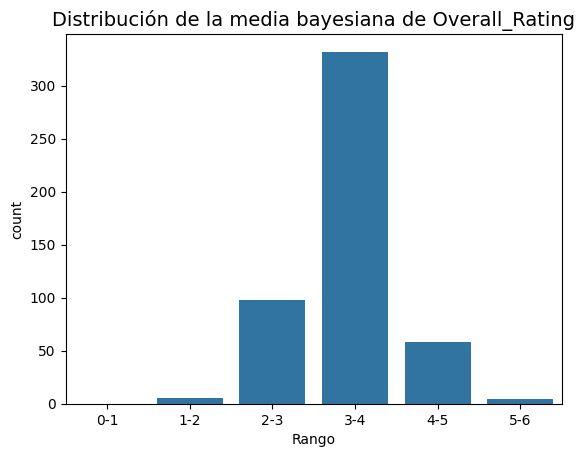

In [49]:
puntuacionBayesiana['Rango']=puntuacionBayesiana['Puntuacion Bayesiana'].apply(determinar_rango)
clasificacion = puntuacionBayesiana['Rango'].value_counts()
sns.countplot(x='Rango', data=puntuacionBayesiana, order=['0-1','1-2','2-3','3-4','4-5','5-6'])
plt.title("Distribución de la media bayesiana de Overall_Rating", fontsize=14)
plt.show()

Como podemos observar, la mayoría de las aerolíneas tienen una media de valoración entre 3 y 4.

### 2. Recomendador basado en el tipo de asiento

Ahora vamos a tener en cuenta también en qué tipo de asiento ha viajado cada pasajero, para hacer una valoración más ajustada a las características del usuario. Una vez hayamos filtrado las valoraciones por tipo de asiento, haremos la media bayesiana de nuevo para recomendar una aerolínea.

In [50]:
def recomendadorPorTipoAsiento(seat):  
    aerolineas['Seat Type'] = aerolineas['Seat Type'].astype(str)
    valoracionesDeEseTipoDeAsiento = aerolineas[aerolineas['Seat Type'] == seat]
    estadisticasAerolineas = valoracionesDeEseTipoDeAsiento.groupby('Airline Name')['Overall_Rating'].agg(['count', 'mean'])
    C=estadisticasAerolineas['count'].mean()
    m=estadisticasAerolineas['mean'].mean()
    puntuacionBayesiana=valoracionesDeEseTipoDeAsiento.groupby('Airline Name')['Overall_Rating'].agg(bayesian_avg).reset_index()
    puntuacionBayesiana.columns=['Airline Name', 'Puntuacion Bayesiana'] #puntuacionBayesiana es un DataFrame que recoge el nombre de cada aerolinea y la media Bayesiana de sus valoraciones (del campo Overall_Rating).
    puntuacionBayesiana = puntuacionBayesiana.sort_values('Puntuacion Bayesiana', ascending=False)
    return puntuacionBayesiana


In [51]:
recomendadorPorTipoAsiento('Economy Class')

,Airline Name,Puntuacion Bayesiana
339,QantasLink,5.181471
145,China Southern Airlines,5.018752
263,Lao Airlines,4.880023
137,Cathay Dragon,4.874492
163,Dragonair,4.862306
...,...,...
374,Silver Airways,1.999958
461,Volaris,1.999958
393,Spirit Airlines,1.992862
226,Interjet,1.979259


Vemos que para un usuario que vaya a viajar en Economy Class, la aerolínea más recomendable es QantasLink, mientras que la menos recomendable sigue siendo Frontier Airlines.

### 3. Recomendador basado en filtrado colaborativo item-item

En nuesto dataframe no tenemos realmente ningún identificador de usuario, por lo que se podría considerar que cada review es un usuario diferente. Sin embargo, esto no nos da mucha información sobre las preferencias de cada usuario. Por tanto, vamos a suponer que tenemos un dataframe que sí tiene un campo ID Usuario, de tal forma que cada usuario puede haber dejado varias reviews sobre experiencias diferentes. Para ello, vamos a añadir a nuestro dataframe una columna ID Usuario, asignando a cada reseña un número aleatorio del 1 al 100, para poder suponer que tenemos 100 usuarios y que cada uno ha hecho una serie de reseñas.

In [52]:
aerolineas['ID Usuario'] = np.random.randint(1, 101, size=len(aerolineas))
aerolineas=aerolineas.fillna(0) #Para que no nos de error, reemplazamos los valores NaN por 0.
aerolineas.head()

,Unnamed: 0,Airline Name,Overall_Rating,Review_Title,Review Date,Verified,Review,Aircraft,Type Of Traveller,Seat Type,...,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Ground Service,Inflight Entertainment,Wifi & Connectivity,Value For Money,Recommended,ID Usuario
0,0,AB Aviation,9.0,"""pretty decent airline""",11th November 2019,True,Moroni to Moheli. Turned out to be a pretty ...,0,Solo Leisure,Economy Class,...,November 2019,4.0,5.0,4.0,4.0,0.0,0.0,3.0,yes,35
1,1,AB Aviation,1.0,"""Not a good airline""",25th June 2019,True,Moroni to Anjouan. It is a very small airline...,E120,Solo Leisure,Economy Class,...,June 2019,2.0,2.0,1.0,1.0,0.0,0.0,2.0,no,67
2,2,AB Aviation,1.0,"""flight was fortunately short""",25th June 2019,True,Anjouan to Dzaoudzi. A very small airline an...,Embraer E120,Solo Leisure,Economy Class,...,June 2019,2.0,1.0,1.0,1.0,0.0,0.0,2.0,no,43
3,3,Adria Airways,1.0,"""I will never fly again with Adria""",28th September 2019,False,Please do a favor yourself and do not fly wi...,0,Solo Leisure,Economy Class,...,September 2019,1.0,1.0,0.0,1.0,0.0,0.0,1.0,no,44
4,4,Adria Airways,1.0,"""it ruined our last days of holidays""",24th September 2019,True,Do not book a flight with this airline! My fr...,0,Couple Leisure,Economy Class,...,September 2019,1.0,1.0,1.0,1.0,1.0,1.0,1.0,no,31


In [53]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Genera una matriz dispersa a partir del marco de datos de calificaciones.
    
    Argumentos:
        df: dataframe de pandas que contiene 3 columnas (userId, movieId, rating)
    
    Devoluciones:
        X: matriz dispersa
        user_mapper: dict que asigna las identificaciones de usuario a los índices de usuario.
        user_inv_mapper: dict que asigna índices de usuario a ID de usuario
        airline_mapper: dict que asigna los nombres de las aerolíneas a los índices de las reviews
        airline_inv_mapper: dict que asigna índices de reviews a nombres de aerolíneas
        
    """
    M = df['ID Usuario'].nunique()
    N = df['Airline Name'].nunique()

    user_mapper = dict(zip(np.unique(df['ID Usuario']), list(range(M))))
    airline_mapper = dict(zip(np.unique(df['Airline Name']), list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df['ID Usuario'])))
    airline_inv_mapper = dict(zip(list(range(N)), np.unique(df['Airline Name'])))
    
    user_index = [user_mapper[i] for i in df['ID Usuario']]
    item_index = [airline_mapper[i] for i in df['Airline Name']]

    X = csr_matrix((df["Overall_Rating"], (user_index,item_index)), shape=(M,N))
    
    return X, user_mapper, airline_mapper, user_inv_mapper, airline_inv_mapper

In [54]:
from sklearn.neighbors import NearestNeighbors

def find_similar_airlines(nombreAerolinea, X, airline_mapper, airline_inv_mapper, k, metric='cosine'):
    """
    Encuentra los k vecinos más cercanos para una aerolínea dada.
    
    Argumentos:
        nopmbreAerolinea: nombre de la aerolínea de interés
        X: matriz de utilidad user-item
        k: número de aerolíneas similares que queremos recuperar
        métrica: métrica de distancia para los cálculos de kNN
    
    Salida: devuelve una lista de k ID de aerolíneas similares
    """
    X = X.T
    neighbour_ids = []
    
    airline_ind = airline_mapper[nombreAerolinea]
    airline_vec = X[airline_ind]
    if isinstance(airline_vec, (np.ndarray)):
        airline_vec = airline_vec.reshape(1,-1)
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric) 
    kNN.fit(X)
    neighbour = kNN.kneighbors(airline_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(airline_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [55]:
def encontrarSimilares(nombreAerolinea):
    X, user_mapper, airline_mapper, user_inv_mapper, airline_inv_mapper = create_X(aerolineas) #Calculamos la matriz dispersa X
    nRatingsPerAirline = X.getnnz(axis=0)
    sumRatingsPerAirline = X.sum(axis=0)
    meanRatingPerAirline = sumRatingsPerAirline/nRatingsPerAirline    
    X_mean_airline = np.tile(meanRatingPerAirline, (X.shape[0],1)) #En cada columna tenemos la calificación promedio de cada aerolínea.
    X_norm = X - csr_matrix(X_mean_airline) #Normalización de la matriz X
    aerolineasSimilares = find_similar_airlines(nombreAerolinea, X_norm, airline_mapper, airline_inv_mapper, k=10)
    print(f"Si has disfrutado de una buena experiencia de viaje con {nombreAerolinea}, te recomendamos opciones similares para tus próximos viajes:")
    for i in aerolineasSimilares:
        print(i)
    

In [56]:
encontrarSimilares('AB Aviation')

Si has disfrutado de una buena experiencia de viaje con AB Aviation, te recomendamos opciones similares para tus próximos viajes:
Somon Air
Safarilink
Trigana Air
Air North Yukon's Airline
Iberojet
Eritrean Airlines
Pan Pacific Airlines
Air Labrador
Novair


Como podemos observar, si por ejemplo buscamos aerolíneas similares a AB Aviation, nos da una lista de las 10 aerolíneas más similares basándose en el filtrado colaborativo item-item.